In [1]:
import os
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from typing import List, Sequence
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, MessageGraph # MessageGraph to pass messages along between nodes
from dotenv import load_dotenv, find_dotenv

In [2]:
load_dotenv(find_dotenv())

True

In [3]:
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are a twitter techie influencer assistant tasked with writing excellent twitter posts.
            Generate the best twiiter post possible for the user's request.
            IF the user provides critique, respond with a revised version of your previous attempts
            """
        ),
        MessagesPlaceholder(variable_name="messages")
    ]
)


reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are a viral twitter influencer grading a tweet. Generate critique and recommmendations for the user's tweet.
            Always provide detailed recommendations, including requests for length, virality, style etc.
            """
        ),
        MessagesPlaceholder(variable_name="messages")
    ]
)

In [4]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
# llm = ChatOpenAI(model="gpt-4.1-mini")

In [5]:
generation_chain = generation_prompt | llm
reflection_chain = reflection_prompt | llm

In [6]:
GENERATE = "generate"
REFLECT = "reflect"

In [7]:
def generate_node(state):
    return generation_chain.invoke(
        {
            "messages": state
        }
    )

In [8]:
def reflection_node(state):
    response =  reflection_chain.invoke(
        {
            "messages": state
        }
    )
    # to trick the system to think, the critique is done by Human
    return [HumanMessage(content=response.content)]

In [9]:
def should_continue(state):
    if len(state) > 4:
        return "end"
    return "continue"

In [10]:
graph = MessageGraph()
graph.set_entry_point(GENERATE)
graph.add_node(GENERATE, generate_node)
graph.add_node(REFLECT, reflection_node)
graph.add_conditional_edges(
    GENERATE,
    should_continue,
    {
        "continue": REFLECT,
        "end": END
    }
)
graph.add_edge(REFLECT, GENERATE)
app = graph.compile()

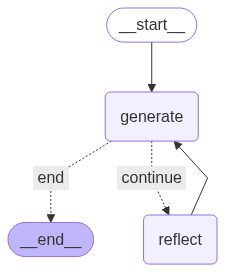

In [11]:
app

In [12]:
app.invoke(HumanMessage(content="AI Agents taking over content creation"))

F:\PlayGround\GEN_AI\Agents\with_langgraph\.venv\Lib\site-packages\langchain_google_genai\chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(
F:\PlayGround\GEN_AI\Agents\with_langgraph\.venv\Lib\site-packages\langchain_google_genai\chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(
F:\PlayGround\GEN_AI\Agents\with_langgraph\.venv\Lib\site-packages\langchain_google_genai\chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


[HumanMessage(content='AI Agents taking over content creation', additional_kwargs={}, response_metadata={}, id='d2c898cb-21ce-448d-88b7-fc8a74ac969d'),
 AIMessage(content="Okay, here are a few options for a tweet about AI agents and content creation, playing with different angles:\n\n**Option 1 (Intriguing & Slightly Provocative):**\n\n> AI agents are now writing articles, designing graphics, and even composing music. Are we on the verge of a content creation singularity? 🤖 #AI #ContentCreation #ArtificialIntelligence #FutureofWork\n\n**Option 2 (Focus on Efficiency & Opportunity):**\n\n> AI agents are revolutionizing content creation! Automating tasks, boosting efficiency, and freeing up human creatives to focus on strategy & innovation.  Exciting times ahead! ✨ #AIagents #ContentMarketing #Automation #Innovation\n\n**Option 3 (More Balanced & Realistic):**\n\n> AI agents are making waves in content creation, but it's not about replacement, it's about augmentation.  Think smarter work